In [3]:
!pip install tensorflow==2.5.0
!pip install gym
!pip install keras
!pip install keras-rl2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.2 which is incompatible.
bokeh 2.4.2 requires typing-extensions>=3.10.0, but you have typing-extensions 3.7.4.3 which is incompatible.



  Using cached tensorflow-2.5.0-cp39-cp39-win_amd64.whl (422.6 MB)
  Using cached h5py-3.1.0-cp39-cp39-win_amd64.whl (2.7 MB)
  Using cached grpcio-1.34.1-cp39-cp39-win_amd64.whl (2.9 MB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached numpy-1.19.5-cp39-cp39-win_amd64.whl (13.3 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: flatbuff

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
bokeh 2.4.2 requires typing-extensions>=3.10.0, but you have typing-extensions 3.7.4.3 which is incompatible.


#  Build Environment

In [3]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [4]:
random.seed(22)

In [41]:
class VehEnv(Env):
    def __init__(self,visualize,traffic_lights):
        self.traffic_lights = traffic_lights
        
        # number of actions (accelerations)- Discrete is discrete set of values
        self.action_space = Discrete(11)                         
        # upper and lower bounds for speed- Box is continuous set of values- normalize?
        self.observation_space = Box(low=np.array([0.0, 0.0, 0.0,0]), high = np.array([40.0/40.0, 1000/1000,40/40,1])) 
        
        # parameters for normilization
        self.speed_max = 40
        self.dist_max = 1000
        self.time_max = 40
        
        
        # start parameters
        self.traffic_lights.reset()
        next_pos = self.traffic_lights.get_info()[0][0]
        self.prev_light_pos = self.traffic_lights.get_info()[0][0]
        next_phase = self.traffic_lights.get_info()[0][3]
        if next_phase == 0:
             next_time = self.traffic_lights.get_info()[0][2]
        else:
            next_time = self.traffic_lights.get_info()[0][1]
        self.x = 0 
        self.state = [self.normalize(self.speed_max,random.randint(0,35)), self.normalize(self.dist_max,next_pos),self.normalize(self.time_max,next_time), next_phase]

        # set simulation length
        self.sim_length = 1000
        
        self.vis = visualize
        if self.vis:
            global speeds 
            global accel
            global light_vis_info
            speeds = []
            accels = []
            position = []
            light_vis_info = []
        else:
            pass

        
    def step(self,action):
        reward = 0
        
        # map discrete values to discrete acceleration values  between -3 and 2 (y=0.5x-2)
        accel = 0.5*action-3
        # get previous state
        prev_speed = (self.state[0]*self.speed_max/2)+self.speed_max/2
        prev_x = self.x
        # get new speed and position and SPaT data
        speed = prev_speed+ accel
        self.x = prev_x + prev_speed+(speed-prev_speed)/2
        
        # collect data for ran red function
        prev_phase = self.state[3] # previous phase 

        # change traffic lights
        self.traffic_lights.step()
    
        # drop simulation time every time step
        self.sim_length -= 1
        

        

        # check next light info
        y = self.check_next_light(self.x)
        next_light_pos = self.traffic_lights.get_info()[y][0]
        next_pos = next_light_pos-self.x
        next_phase = self.traffic_lights.get_info()[y][3]
        if next_phase == 0:
             next_time = self.traffic_lights.get_info()[y][2]
        else:
            next_time = self.traffic_lights.get_info()[y][1]
        
        # check if light was ran
        if self.prev_light_pos !=  next_light_pos:
            reward += self.ran_red(prev_phase)
    
        # only do this if visualization is necessary 
        if self.vis:
            speeds.append(speed)
            accels.append(accel)
            positions.append(self.x)
#             print(self.state)
            info = self.traffic_lights.get_info()
            lights_at_time_step = []
            for i in range(0,len(info)):   
                lights_at_time_step.append([info[i][0],info[i][3]])
            light_vis_info.append(lights_at_time_step)
        else:
            pass     
        
        # reward function
#         error = (speed-25)**2
#         reward = reward + -2/(1+2.7**(-0.05*error))+2
        reward = reward + 1/(2.7**(0.5*accel**2))

        

        
    
        # check if simulation is done
        last_light = self.traffic_lights.get_info()[len(self.traffic_lights.get_info())-1][0]
        if self.sim_length <= 0 or speed < 0 or self.x >= last_light or reward < 0:
#             print(self.sim_length)
#             print("Ending speed is {}".format(speed))
#             print("Ending position is {}".format(self.x))
#             print("Ending light reward is {}".format(self.ran_red(prev_phase)))
            done = True
        else:
            done = False
            
    
        # return step information
        self.prev_light_pos = next_light_pos
        self.state = [self.normalize(self.speed_max,speed), self.normalize(self.dist_max,next_pos),self.normalize(self.time_max,next_time), next_phase]
        info = {}
#         print(self.state)
#         print(self.x)
        return self.state, reward, done, info
     
    def ran_red(self,prev_phase):
        # the light could turn green or red at an interval we don't check... this will be fixed later
        # the light will only check at the last phase before it passes
        if prev_phase == 1:
#             print('didn\'t run red')
            return 10
        elif prev_phase == 0:
#             print('ran red')
            return -10
            

        
    
    def check_next_light(self,x):
        c = self.traffic_lights.get_info()
        if x < c[0][0]:
            y = 0
        if x > c[len(c)-1][0]:
            y = len(c)-1
        else:
            for i in range(0,len(c)-1):
                if x >= c[i][0] and x <= c[i+1][0]:
                    y = i + 1
        return y
        
    def normalize(self,max,x):
        normed = (x-max/2)/(max/2)
        return normed
        
    def render(self):
        pass
    
    
    
    def reset(self):
        
        # reset initial conditions
        self.traffic_lights.reset()
        next_pos = self.traffic_lights.get_info()[0][0]
        next_phase = self.traffic_lights.get_info()[0][3]
        if next_phase == 0:
             next_time = self.traffic_lights.get_info()[0][2]
        else:
            next_time = self.traffic_lights.get_info()[0][1]
        self.x = 0
        self.state = [self.normalize(self.speed_max,random.randint(0,35)), self.normalize(self.dist_max,next_pos),self.normalize(self.time_max,next_time), next_phase]
        
        # reset time
        self.sim_length = 1000
        if self.vis:
            speeds = []
            accels = []
            positions = []
            light_vis_info = []
        else:
            pass
        
        return self.state
        

In [42]:
class TrafficLight():
    def __init__(self,position,green_time,red_time):
        # green is 1, red is 0
        self.initial_green_time = green_time
        self.initial_red_time = red_time
        self.initial_position = position
        self.position = position
        self.green_time = green_time
        self.red_time = red_time
        self.phase =random.randint(0,1)
    
    def reset(self):
        self.position = self.initial_position
        self.green_time = self.initial_green_time
        self.red_time = self.initial_red_time
        self.phase = random.randint(0,1)

    def step(self):
        if self.phase == 1:
            self.green_time -= 1
        elif self.phase == 0:
            self.red_time -= 1

        if self.green_time <= 0:
            self.phase = 0
            self.green_time = self.initial_green_time
        elif self.red_time <= 0:
            self.phase = 1
            self.red_time = self.initial_red_time
        return None
    
    def get_info(self): 
        return [self.position, self.green_time, self.red_time,self.phase]

In [43]:
class Corridor():
    def __init__(self,*args):
        self.y = [x for x in args]
        
    def step(self):
        for x in self.y:
            x.step()
            
    def reset(self):
        for x in self.y:
            x.reset()
        
    def get_info(self):
        return [x.get_info() for x in self.y]

In [44]:
# # Test light class
# TL = TrafficLight(20,30,25)    # position, green_time, red_time
# for i in range(1,920):
#     TL.step()
# print(TL.get_info())
# TL1 = TrafficLight(20,3,25) 
# TL2 = TrafficLight(20,30,25) 
# TL3 = TrafficLight(20,40,25) 

In [45]:
# # Test corridor class
# c = Corridor(TL1,TL2,TL3)
# print(c.get_info())
# for i in range(1,20):
#     c.step()
# print(c.get_info())

In [119]:
# build traffic light corridor
TL1 = TrafficLight(500,25,40) 
TL2 = TrafficLight(1000,35,30) 
TL3 = TrafficLight(1500,40,30) 
TL4 = TrafficLight(3000,35,40)
TL5 = TrafficLight(3500,35,40)
TL6 = TrafficLight(4000,35,40)
TL7 = TrafficLight(5000,35,40)

TL8 = TrafficLight(6000,25,40) 
TL9 = TrafficLight(7000,35,30) 
TL10 = TrafficLight(10000,40,30) 
TL11= TrafficLight(11000,35,40)
TL12= TrafficLight(12000,35,40)
TL13= TrafficLight(13000,35,40)
TL14= TrafficLight(14000,35,40)

corridor = Corridor(TL1,TL2,TL3,TL4,TL5,TL6,TL7,TL8,TL9,TL10,TL11,TL12,TL13,TL14)
# build environment
env = VehEnv(False, corridor)
corridor.get_info()

C:\Users\bking\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[500, 25, 40, 1],
 [1000, 35, 30, 0],
 [1500, 40, 30, 0],
 [3000, 35, 40, 1],
 [3500, 35, 40, 1],
 [4000, 35, 40, 0],
 [5000, 35, 40, 0],
 [6000, 25, 40, 0],
 [7000, 35, 30, 1],
 [10000, 40, 30, 0],
 [11000, 35, 40, 0],
 [12000, 35, 40, 1],
 [13000, 35, 40, 1],
 [14000, 35, 40, 0]]

In [120]:
env.observation_space.sample()

array([0.1657341 , 0.8214972 , 0.06029052, 0.8095498 ], dtype=float32)

In [121]:
## Testing car matches with matlab and other Python model
# state = env.reset()
# done = False
# score = 0
# for i in range(1,21):
#     action = env.step(10)
    
    

In [122]:
episodes = 1
for episode in range(1,episodes+1):
    state = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render()
        action = env.action_space.sample()  
        n_state, reward, done, info = env.step(action)
        score+= reward
        print(n_state)
    print('Episode:{} Score:{}'.format(episode,score))
    


[-0.4, -0.026, 0.2, 1]
[-0.425, -0.0495, 0.15, 1]
[-0.4, -0.073, 0.1, 1]
[-0.4, -0.097, 0.05, 1]
[-0.45, -0.12, 0.0, 1]
[-0.45, -0.142, -0.05, 1]
[-0.475, -0.1635, -0.1, 1]
[-0.45, -0.185, -0.15, 1]
[-0.5, -0.206, -0.2, 1]
[-0.5, -0.226, -0.25, 1]
[-0.5, -0.246, -0.3, 1]
[-0.6, -0.264, -0.35, 1]
[-0.625, -0.2795, -0.4, 1]
[-0.625, -0.2945, -0.45, 1]
[-0.55, -0.311, -0.5, 1]
[-0.55, -0.329, -0.55, 1]
[-0.675, -0.3445, -0.6, 1]
[-0.75, -0.356, -0.65, 1]
[-0.7, -0.367, -0.7, 1]
[-0.725, -0.3785, -0.75, 1]
[-0.625, -0.3915, -0.8, 1]
[-0.75, -0.404, -0.85, 1]
[-0.675, -0.4155, -0.9, 1]
[-0.65, -0.429, -0.95, 1]
[-0.775, -0.4405, 1.0, 0]
[-0.9, -0.447, 0.95, 0]
[-0.975, -0.4495, 0.9, 0]
[-0.875, -0.4525, 0.85, 0]
[-0.975, -0.4555, 0.8, 0]
[-1.025, -0.4555, 0.75, 0]
Episode:1 Score:16.790884338313877


# Build DQN Model

In [78]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

In [79]:
states = env.observation_space.shape
actions = env.action_space.n

In [80]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states[0])))
    model.add(Dense(128, activation='relu', input_shape = (1,states[0])))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(actions, activation ='linear'))
    return model

In [81]:
try:
    del model
except:
    pass

In [82]:
model = build_model(states, actions)

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 11)                1419      
Total params: 18,571
Trainable params: 18,571
Non-trainable params: 0
_________________________________________________________________


# Build Agent 

In [99]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

### Load a Saved Model

In [100]:
model = keras.models.load_model('Random_Lights_Long_Working_Model_Long_Training')

In [101]:
def build_agent(model, acitons):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=100000, window_length =1)
    dqn = DQNAgent(model=model, memory=memory, policy= policy, nb_actions=actions, nb_steps_warmup=10, target_model_update = 1e-2)
    return dqn

In [102]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics = ['mae'])

### Create a New Model

In [111]:
history = dqn.fit(env, nb_steps =50000, visualize=False, verbose =1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 131s 13ms/step - reward: 0.7365
87 episodes - episode_reward: 82.126 [-9.989, 374.749] - loss: 46.966 - mae: 99.465 - mean_q: 112.686

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 135s 13ms/step - reward: 0.7578
70 episodes - episode_reward: 111.079 [-9.989, 397.742] - loss: 43.925 - mae: 100.572 - mean_q: 113.806

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: 0.7565
76 episodes - episode_reward: 96.150 [-9.989, 356.716] - loss: 44.615 - mae: 103.444 - mean_q: 116.981

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 138s 14ms/step - reward: 0.8068
47 episodes - episode_reward: 173.835 [-9.955, 423.706] - loss: 42.925 - mae: 103.348 - mean_q: 116.522

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 140s 14ms/step - rew

In [128]:
# model.save('Random_Lights_Long_Working_Model_v3')

In [129]:
scores = dqn.test(env, nb_episodes = 100, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: 558.910, steps: 677
Episode 2: reward: 589.504, steps: 677
Episode 3: reward: 101.843, steps: 125
Episode 4: reward: -9.673, steps: 1
Episode 5: reward: 628.233, steps: 728
Episode 6: reward: 44.820, steps: 65
Episode 7: reward: -9.673, steps: 1
Episode 8: reward: 609.164, steps: 718
Episode 9: reward: -9.673, steps: 1
Episode 10: reward: 639.626, steps: 752
Episode 11: reward: -9.673, steps: 1
Episode 12: reward: 96.396, steps: 128
Episode 13: reward: -9.673, steps: 1
Episode 14: reward: 36.488, steps: 65
Episode 15: reward: 269.008, steps: 299
Episode 16: reward: 628.132, steps: 718
Episode 17: reward: -9.117, steps: 1
Episode 18: reward: 276.811, steps: 330
Episode 19: reward: -9.955, steps: 1
Episode 20: reward: 328.259, steps: 369
Episode 21: reward: -9.673, steps: 1
Episode 22: reward: 306.159, steps: 339
Episode 23: reward: 532.270, steps: 623
Episode 24: reward: -9.117, steps: 1
Episode 25: reward: 573.333, steps: 690
Episode 26: 

# Visualize Data

In [130]:
import matplotlib.pyplot as plt

## Build Env for Visualization

In [131]:
env_vis = VehEnv(True,corridor)

C:\Users\bking\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [132]:
speeds = []
accels = []
positions = []
test1 = dqn.test(env_vis, nb_episodes = 1, visualize=False)

Testing for 1 episodes ...
Episode 1: reward: 326.982, steps: 371


In [133]:
y=np.array(list(range(len(speeds))))

<function matplotlib.pyplot.show(close=None, block=None)>

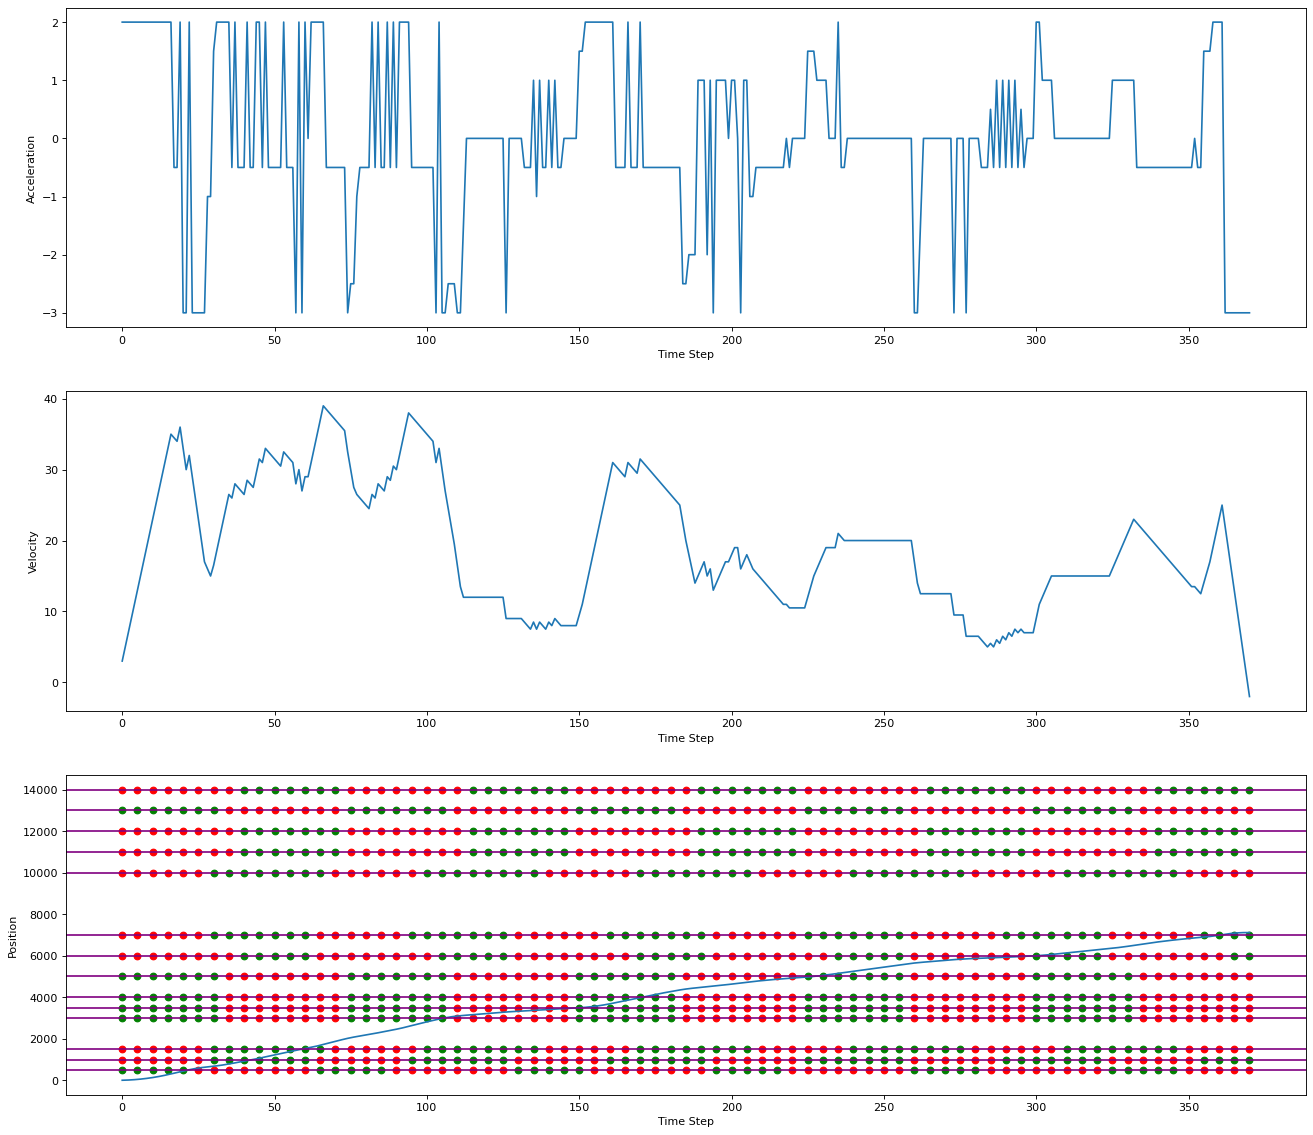

In [134]:
plt.figure(1,figsize=(20, 18), dpi=80)
plt.subplot(3,1,1)
plt.plot(y,accels)
plt.xlabel("Time Step")
plt.ylabel("Acceleration")
plt.subplot(3,1,2)
plt.plot(y,speeds)
plt.xlabel("Time Step")
plt.ylabel("Velocity")
plt.subplot(3,1,3)
plt.plot(y,positions)
for i in range(0,len(corridor.get_info())):
    plt.axhline(corridor.get_info()[i][0],color='purple')
for i in range(0,len(positions),5):
    for j in range(0,len(light_vis_info[i])):
        if light_vis_info[i][j][1] == 1:
            plt.scatter(i,light_vis_info[i][j][0],color="green" )
        if light_vis_info[i][j][1] == 0:
            plt.scatter(i,light_vis_info[i][j][0],color="red" )   
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.show

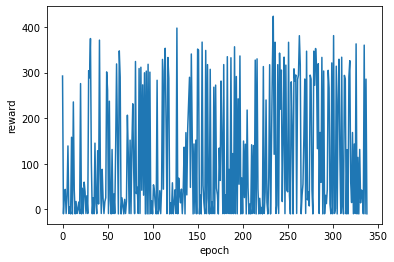

In [112]:
# summarize history for accuracy
plt.plot(history.history['episode_reward'])
plt.ylabel('reward')
plt.xlabel('epoch')
plt.show()


# Get Weights

In [407]:
model.get_weights()

[array([[-3.51486564e-01, -9.17321444e-01,  4.48804945e-02,
          1.67704120e-01, -7.14661956e-01, -2.04651022e+00,
          6.83152139e-01,  7.39090979e-01, -4.57828259e-03,
         -1.44866467e-01, -2.11920049e-02, -7.46765286e-02,
         -3.79424021e-02,  4.93624270e-01,  1.86218888e-01,
          3.30792777e-02, -5.20428777e-01,  2.99039632e-01,
          1.09080419e-01, -1.02282143e+00, -3.91601436e-02,
         -1.05339415e-01,  2.36935067e+00,  6.41291738e-02],
        [ 1.98597880e-03,  1.22762847e+00,  1.36760211e+00,
         -7.66754210e-01,  2.06224751e+00, -4.63795543e-01,
         -7.57777616e-02,  3.15483600e-01, -7.16569245e-01,
         -5.91301084e-01,  1.25003350e+00, -1.03176141e+00,
          1.63420212e+00, -4.87945825e-02, -2.09668502e-01,
          1.51326552e-01, -1.11144520e-01, -9.04081762e-01,
         -4.34593052e-01,  1.50683701e+00, -1.32128477e+00,
         -3.93076360e-01, -3.51984113e-01,  2.51550651e+00],
        [-5.48805773e-01,  3.51876915e